<a href="https://colab.research.google.com/github/saikothapalli16/comp560final/blob/main/SISA_Machine_Unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All imports with a check to run on GPU

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
(ds_train_org, ds_test_org), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Import of data set

Train Neural Network using standard procedure batch size of 500, code sie of 64, and hiden layer size of 128

In [ ]:
N_batch = 128
nnet = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])
nnet.build([N_batch,14*14])

In [ ]:
def loss(X, Ypix, Ylbls, nnet):
  """
  Args:
    X: N_batch x 14*14 matrix of downsampled inputs
    Ypix: N_batch x ?? matrix of upsampling target pixels
    Ylbls: N_batch length array of integers indicating class labels
  Returns:
    loss: scalar of mse_regression_loss + classification_loss for batch
  """
  nnet_output = nnet(X)
  pix_output = nnet_output[:, :-10]
  logit_output = nnet_output[:, -10:]
  # mse_loss should be a mean of the squared error of the upsample estimates,
  # averaged over all instances (and outputs) in the batch
  # MAKE SURE TO USE TENSORFLOW FUNCTIONS AND OPERATIONS (IE NOT NUMPY)
  mse_loss = tf.reduce_mean(tf.multiply(Ypix-pix_output,Ypix-pix_output))  # TODO

  # class_loss should be a mean of the cross entropy loss of the
  # averaged over all instances in the batch
  # hint: use (tf.nn.sparse_softmax_cross_entropy_with_logits)
  # MAKE SURE TO USE TENSORFLOW FUNCTIONS AND OPERATIONS (IE NOT NUMPY)
  class_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylbls,logit_output))  # TODO

  return mse_loss + class_loss


def grad(X,Y,lbl,nnet):
    with tf.GradientTape() as tape:
        loss_value = loss(X,Y,lbl,nnet)
    return loss_value, tape.gradient(loss_value, nnet.weights)

In [ ]:
mask = (np.mod(np.arange(28), 2)[:, None]>0)*(np.mod(np.arange(28), 2)[None, :]>0)

def normalize(image, label):
    vectorized = tf.reshape(image, (-1,))
    return(
        tf.cast(vectorized[mask.flatten()],tf.float32)/255.,
        tf.cast(vectorized[~mask.flatten()],tf.float32)/255.,
        label
    )

ds_train = ds_train_org.map(normalize,num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test_org.map(normalize,num_parallel_calls=tf.data.AUTOTUNE)

# Create 5 disjoint shards of ds_train
ds_train_shards = []
num_shards = 5
for i in range(num_shards):
    ds_train_shards.append(ds_train.shard(num_shards=num_shards, index=i))

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
num_epochs = 15
for i in range(num_epochs):
  for X,Y,label in ds_train.batch(N_batch,drop_remainder=True):
    grads = grad(X,Y,label,nnet)
    optimizer.apply_gradients(zip(grads[1], nnet.weights))
  print(f"Loss {i} = {grads[0]}")

Loss 0 = 0.2045317143201828
Loss 1 = 0.127943754196167
Loss 2 = 0.10169851779937744
Loss 3 = 0.08218014240264893
Loss 4 = 0.06887968629598618
Loss 5 = 0.05277049541473389
Loss 6 = 0.040977343916893005
Loss 7 = 0.031236696988344193
Loss 8 = 0.025565888732671738
Loss 9 = 0.02666906639933586
Loss 10 = 0.024544481188058853
Loss 11 = 0.02385285682976246
Loss 12 = 0.029938440769910812
Loss 13 = 0.022287564352154732
Loss 14 = 0.020167380571365356


tf.Tensor(
[[-16.618755    15.717067    -9.787597   ...  -1.921372     0.1506637
  -13.001608  ]
 [-16.230001    16.943165    -2.6556108  ...   0.18975845  -2.3781538
  -12.532801  ]
 [ 20.383175   -11.025553   -13.139029   ...  -9.608589   -27.965511
   -1.3685341 ]
 ...
 [-24.967876    -5.7466006   -5.2538176  ...  -1.6144736   -4.743458
  -13.063334  ]
 [-17.41163     12.166512    -9.033085   ...  -2.7638245   -3.2406178
   -7.634598  ]
 [ 20.66019    -18.426712   -11.149435   ...  -6.1641006  -21.062103
   -3.4910316 ]], shape=(128, 10), dtype=float32)


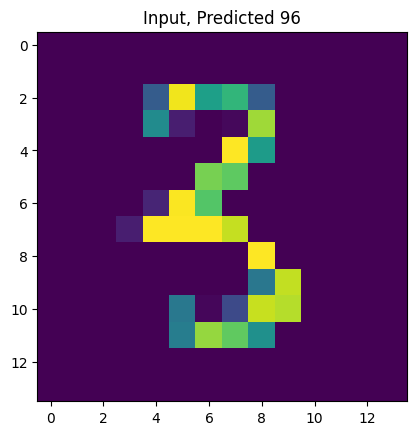

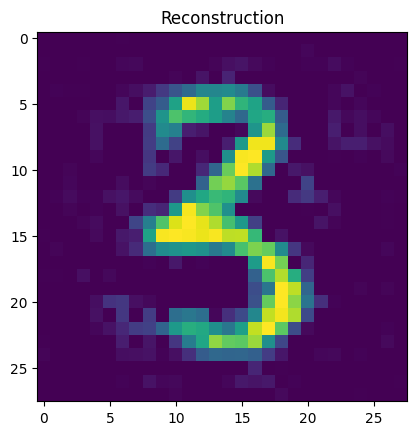

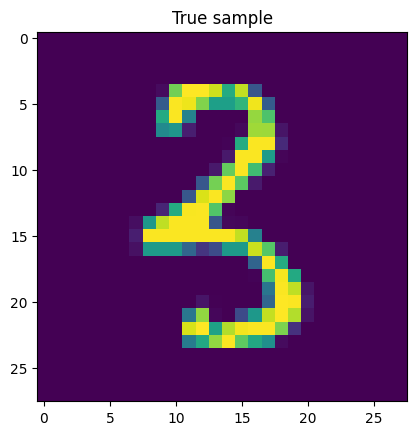

In [ ]:
nnet_output = nnet(X)
pix_output = nnet_output[:,:-10]
logits_output = nnet_output[:,-10:]

print(logits_output)

r_instance = np.random.randint(0,X.shape[0])
predicted = r_instance

plt.figure()
plt.title('Input, Predicted {}'.format(predicted))
plt.imshow(np.reshape(X[predicted],(14,14)))

plt.figure()
plt.title('Reconstruction')
x_recon = np.zeros((28*28),dtype = np.float32)

row = False
ind_pred = 0
ind_true = 0

for i in range(28*28):
  if i%28==0:
    row = not row
  if row:
    x_recon[i] = pix_output[r_instance, ind_pred]
    ind_pred += 1
  else:
    if i%2==0:
      x_recon[i] = pix_output[r_instance, ind_pred]
      ind_pred += 1
    else:
      x_recon[i] = X[r_instance, ind_true]
      ind_true += 1

x_recon[x_recon<0.0] = 0.0
x_recon[x_recon>1.0] = 1.0
plt.imshow(np.reshape(x_recon,(28,28)))

plt.figure()
plt.title('True sample')
x_true = np.zeros((28*28),dtype = np.float32)

row = False
ind_true = 0
ind_x = 0

for i in range(28*28):
  if i%28==0:
    row = not row
  if row:
    x_true[i] = Y[r_instance, ind_true]
    ind_true += 1
  else:
    if i%2==0:
      x_true[i] = Y[r_instance, ind_true]
      ind_true += 1
    else:
      x_true[i] = X[r_instance, ind_x]
      ind_x += 1


plt.imshow(np.reshape(x_true,(28,28)))

This is our original model trained on half of the data and will serve as our baseline

We will now create the 6 NN that will evaluate over any given shard, our aggregation will simply be the average result

In [ ]:

nnet_s1 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])
nnet_s1.build([N_batch,14*14])

nnet_s2 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])

nnet_s2.build([N_batch,14*14])

nnet_s3 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])

nnet_s3.build([N_batch,14*14])

nnet_s4 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])

nnet_s4.build([N_batch,14*14])

nnet_s5 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])

nnet_s5.build([N_batch,14*14])

nnet_s6 = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(598)
])

nnet_s6.build([N_batch,14*14])



shard_nnets = [nnet_s1, nnet_s2, nnet_s3, nnet_s4, nnet_s5, nnet_s6]

As we now have the indiviual shards we will retrain all of these shards on their partition of the data

In [ ]:
# The num_shards variable is already available from cell 4qXHhNertke2 and has value 5.
# For each of the neural networks in shard_nnets
for j in range(len(shard_nnets)): # Iterate over the 6 NNs
  optimizer = keras.optimizers.Adam(learning_rate=1e-3)
  num_epochs = 15 # Each NN will be trained for 15 epochs
  # Determine which shard this neural network will train on
  # We use the modulo operator to cycle through the 5 shards for the 6 NNs
  current_shard_idx = j % num_shards
  print(f"\nTraining shard_nnets[{j}] on ds_train_shards[{current_shard_idx}]")
  for i in range(num_epochs): # Epochs for the current NN on its assigned shard
    for X,Y,label in ds_train_shards[current_shard_idx].batch(N_batch,drop_remainder=True): # Corrected index
      grads = grad(X,Y,label,shard_nnets[j])
      optimizer.apply_gradients(zip(grads[1], shard_nnets[j].weights))
    print(f"  NN {j}, Epoch {i}: Loss = {grads[0]}")


Training shard_nnets[0] on ds_train_shards[0]
  NN 0, Epoch 0: Loss = 0.3543722927570343
  NN 0, Epoch 1: Loss = 0.26109984517097473
  NN 0, Epoch 2: Loss = 0.21529608964920044
  NN 0, Epoch 3: Loss = 0.18582838773727417
  NN 0, Epoch 4: Loss = 0.15969480574131012
  NN 0, Epoch 5: Loss = 0.13815483450889587
  NN 0, Epoch 6: Loss = 0.11815093457698822
  NN 0, Epoch 7: Loss = 0.10027142614126205
  NN 0, Epoch 8: Loss = 0.0847168117761612
  NN 0, Epoch 9: Loss = 0.07360371202230453
  NN 0, Epoch 10: Loss = 0.06451761722564697
  NN 0, Epoch 11: Loss = 0.056819792836904526
  NN 0, Epoch 12: Loss = 0.049487024545669556
  NN 0, Epoch 13: Loss = 0.04294703155755997
  NN 0, Epoch 14: Loss = 0.03833185136318207

Training shard_nnets[1] on ds_train_shards[1]
  NN 1, Epoch 0: Loss = 0.33021751046180725
  NN 1, Epoch 1: Loss = 0.22262655198574066
  NN 1, Epoch 2: Loss = 0.17140594124794006
  NN 1, Epoch 3: Loss = 0.14544834196567535
  NN 1, Epoch 4: Loss = 0.12534542381763458
  NN 1, Epoch 5: Loss

Aggregate by taking average over the input

In [ ]:
# Create the final aggregated model (same architecture)
nnet_aggregated = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(14*14,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(598)
])
# Note: You only need to specify input_shape or call build on the first layer
# if you want to inspect weights before setting them.
# nnet_aggregated.build([N_batch, 14*14])


# The list of all trained models
shard_nnets = [nnet_s1, nnet_s2, nnet_s3, nnet_s4, nnet_s5, nnet_s6]
num_shards = len(shard_nnets)

# Get the weights from all models
all_weights = [model.get_weights() for model in shard_nnets]

# Get the initial weights from the first model as a starting point for summation
# This is a list of tensors, one for each layer's weights and biases
avg_weights = all_weights[0]

# Sum the weights from the remaining models (index 1 through 5)
for i in range(1, num_shards):
    current_weights = all_weights[i]

    # Check that the number of weight tensors is the same
    if len(avg_weights) != len(current_weights):
        raise ValueError("Models do not have the same number of weight tensors.")

    # Element-wise addition of weights/biases (tensors)
    for j in range(len(avg_weights)):
        avg_weights[j] = avg_weights[j] + current_weights[j]

# Average the summed weights by dividing by the number of shards
for j in range(len(avg_weights)):
    avg_weights[j] = avg_weights[j] / num_shards

# Set the averaged weights to the new aggregated model
nnet_aggregated.set_weights(avg_weights)

print("Model aggregation complete. nnet_aggregated now holds the averaged weights.")

Model aggregation complete. nnet_aggregated now holds the averaged weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


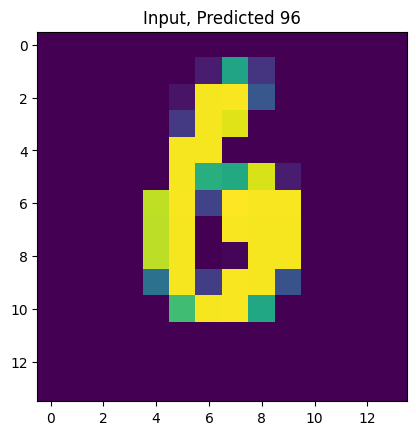

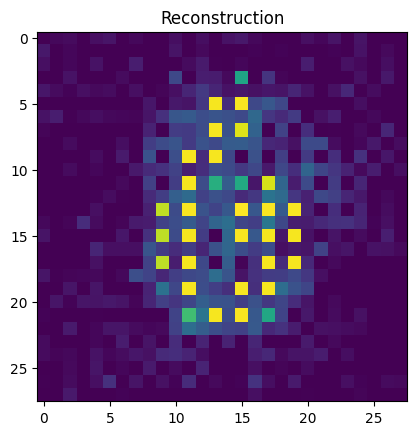

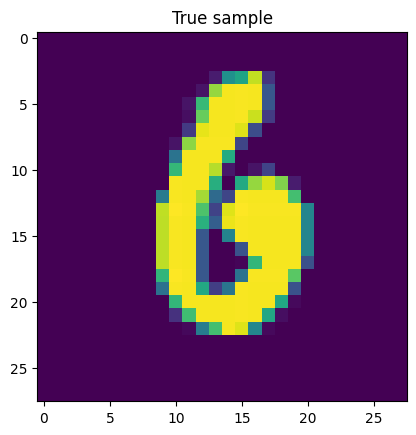

In [ ]:


nnet_output = nnet_aggregated(X)
pix_output = nnet_output[:,:-10]
logits_output = nnet_output[:,-10:]

plt.figure()
plt.title('Input, Predicted {}'.format(predicted))
plt.imshow(np.reshape(X[predicted],(14,14)))

plt.figure()
plt.title('Reconstruction')
x_recon = np.zeros((28*28),dtype = np.float32)

row = False
ind_pred = 0
ind_true = 0

for i in range(28*28):
  if i%28==0:
    row = not row
  if row:
    x_recon[i] = pix_output[r_instance, ind_pred]
    ind_pred += 1
  else:
    if i%2==0:
      x_recon[i] = pix_output[r_instance, ind_pred]
      ind_pred += 1
    else:
      x_recon[i] = X[r_instance, ind_true]
      ind_true += 1

x_recon[x_recon<0.0] = 0.0
x_recon[x_recon>1.0] = 1.0
plt.imshow(np.reshape(x_recon,(28,28)))

plt.figure()
plt.title('True sample')
x_true = np.zeros((28*28),dtype = np.float32)

row = False
ind_true = 0
ind_x = 0

for i in range(28*28):
  if i%28==0:
    row = not row
  if row:
    x_true[i] = Y[r_instance, ind_true]
    ind_true += 1
  else:
    if i%2==0:
      x_true[i] = Y[r_instance, ind_true]
      ind_true += 1
    else:
      x_true[i] = X[r_instance, ind_x]
      ind_x += 1


plt.imshow(np.reshape(x_true,(28,28)))

We see a much worse trainig set, this is likely due to the fact that each model was likely only trained on 1-2 numbers meaning that by taking the average we are getting rid of the ability to predict any number.

if the data was uniformly distributed this would likely not be the case.